# Notebook that predicts characteristics

In [28]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1,2"

import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from statistics import mean
import matplotlib
from tqdm import tqdm

import os
from PIL import Image
from sklearn.metrics import accuracy_score
import torchvision
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data import Dataset, DataLoader, ConcatDataset, SubsetRandomSampler
from torch.optim import lr_scheduler

import torchvision.models as models

plt.style.use('seaborn')

import DiagnosisFunctions.tools as tools

import albumentations as A
import torchvision.transforms.functional as TF
from sklearn.model_selection import KFold
import time
import pickle

In [2]:
print('Take 16')

#Set the notebook to run on the GPU, if available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'This notebook is running on the {device.type}.')
print('')

if device.type == 'cuda':
    torch.cuda.current_device()
    torch.cuda.set_device(1)

    #Set the batch size on cuda
    batch_size = 64

else:
    batch_size = 12

Take 16
This notebook is running on the cpu.



In [3]:
(train_path, train_target), (test_path, test_target) = tools.get_splits_characteristics()

train_set    = tools.CharacteristicsDataset(path = train_path, target = train_target, size = [200, 200])
test_set     = tools.CharacteristicsDataset(path = test_path, target = test_target,   size = [200, 200])

In [4]:
class CNN(nn.Module):
    def __init__(self, n_characteristics = 7, n_diagnosis = 6, n_area = 4):
        super().__init__()
        
        #We can still fine tune it.
        self.base_model = models.resnext50_32x4d(pretrained=True)

        self.fc_characteristics = nn.Linear(in_features = self.base_model.fc.out_features, out_features = n_characteristics)
        self.fc_diagnosis       = nn.Linear(in_features = self.base_model.fc.out_features, out_features = n_diagnosis)
        self.fc_area            = nn.Linear(in_features = self.base_model.fc.out_features, out_features = n_area)

    def forward(self, x):
        #Pass the image through resnet. It's still being trained.
        x = self.base_model(x) 

        #Characteristics pipeline
        x_characteristics = self.fc_characteristics(x)
        x_characteristics = torch.sigmoid(x_characteristics)

        #Diagnosis pipeline
        x_diagnosis = self.fc_diagnosis(x)
        x_diagnosis = torch.softmax(x_diagnosis, dim=-1) #Since it should sum to 1.

        #Area pipeline
        x_area = self.fc_area(x)
        x_area = torch.softmax(x_area, dim=-1)

        x_cat  = torch.cat((x_characteristics, x_diagnosis, x_area), dim=1)
        
        return x_cat

In [5]:
def train_and_eval(phase, model, optimizer, criterion, scheduler, dataloaders):
    if phase == 'train':
        model.train()
    else:
        model.eval()

    running_loss = 0.0

    #Preallocate the probabilities dataframe.
    probabilities = pd.DataFrame(columns = dataloaders[phase].dataset.variables)
    ground_truth  = pd.DataFrame(columns = dataloaders[phase].dataset.variables)

    for inputs, targets, _ in dataloaders[phase]:
        inputs  = inputs.to(device)
        targets = targets.to(device).float()

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            running_loss += loss.item()

        #Append to the dataframes
        probabilities = probabilities.append(pd.DataFrame(outputs.detach().cpu().numpy(), columns = dataloaders[phase].dataset.variables), ignore_index=True)
        ground_truth  = ground_truth.append(pd.DataFrame(targets.detach().cpu().numpy(), columns  = dataloaders[phase].dataset.variables), ignore_index=True)

    if phase == 'train':
        scheduler.step()

    #Return the total loss.
    return running_loss, ground_truth, probabilities

# Training

In [32]:
k = 5
num_epochs = 5

In [33]:
splits = KFold(n_splits=k)

loss = {'train': [[] for _ in range(k)], 'val': [[] for _ in range(k)]}
f1_characteristics = {'train': [[] for _ in range(k)], 'val': [[] for _ in range(k)]}
f1_diagnosis = {'train': [[] for _ in range(k)], 'val': [[] for _ in range(k)]}
f1_area = {'train': [[] for _ in range(k)], 'val': [[] for _ in range(k)]}

for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(train_set)))):
    
    # Define train sampler and val sampler.
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler   = SubsetRandomSampler(val_idx)
    
    train_loader  = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler)
    val_loader    = DataLoader(train_set, batch_size=batch_size, sampler=val_sampler)

    cnn = CNN(n_characteristics = 7, n_diagnosis = 6, n_area = 4).to(device)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(cnn.parameters(), lr=1e-3)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    #Update the dataloaders passed to the training function.
    dataloaders = {'train' : train_loader, 'val' : val_loader}

    for epoch in tqdm(range(num_epochs), desc=f'Fold {fold}', unit='epoch'):
        for phase in ['train', 'val']:
            epoch_loss, gt, p = train_and_eval(phase, cnn, optimizer, criterion, scheduler, dataloaders)

            if phase == 'train':
                avg_obs_loss = (epoch_loss / len(train_idx)) #.detach().cpu()
            elif phase == 'val':
                avg_obs_loss = (epoch_loss / len(val_idx)) #.detach().cpu()

            loss[phase][fold].append(avg_obs_loss)

            # Predict labels based on probabilities
            pred_class = tools.classify_probability_predictions(p)
            
            # Compute f1 scores with average 'samples' (default values)
            characteristics_scores, diagnosis_scores, area_scores = tools.compute_metrics_scores(gt, pred_class)
            f1_characteristics[phase][fold].append(characteristics_scores)
            f1_diagnosis[phase][fold].append(diagnosis_scores)
            f1_area[phase][fold].append(area_scores)

            break
        

#Save the results to a pickle.
with open('statistics.p', 'wb') as output_file:
    pickle.dump([num_epochs, k, loss, f1_characteristics, f1_diagnosis, f1_area], output_file)

if device.type != 'cpu':
    raise NotImplementedError("Let's stop the GPU here!")

Fold 4: 100%|██████████| 5/5 [14:57<00:00, 179.47s/epoch]


# Read the Results

In [34]:
import pickle
import torch

file = open('statistics.p', 'rb')
data = pickle.load(file)
file.close()

nepoch, nfolds, loss, f1_characteristics, f1_diagnosis, f1_area = data

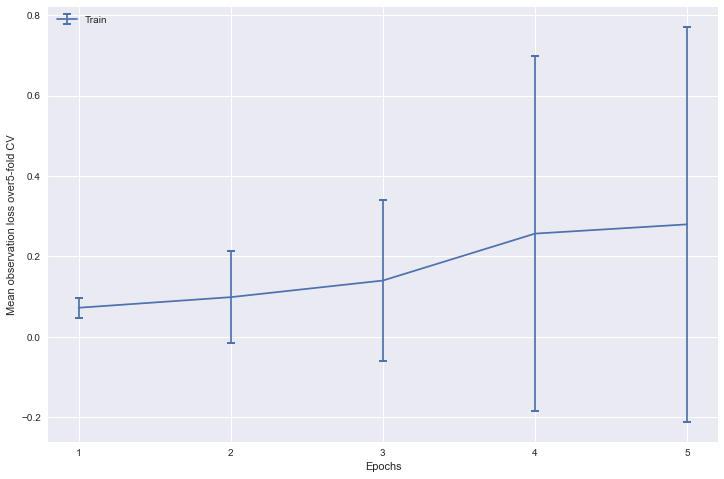

In [37]:
plt.figure(figsize=(12,8))
plt.errorbar(range(nepoch), np.array(loss['train']).T.mean(axis=1), yerr=np.array(loss['train']).T.std(axis=1), capsize=4, capthick=2, label='Train')
#plt.errorbar(range(nepoch), np.array(loss['val']).T.mean(axis=1),   yerr=np.array(loss['val']).T.std(axis=1), capsize=4, capthick=2, label='Validation')
plt.legend()
plt.xticks(range(0,nepoch), range(1,nepoch+1))
plt.xlabel('Epochs')
plt.ylabel('Mean observation loss over5-fold CV')
plt.show()

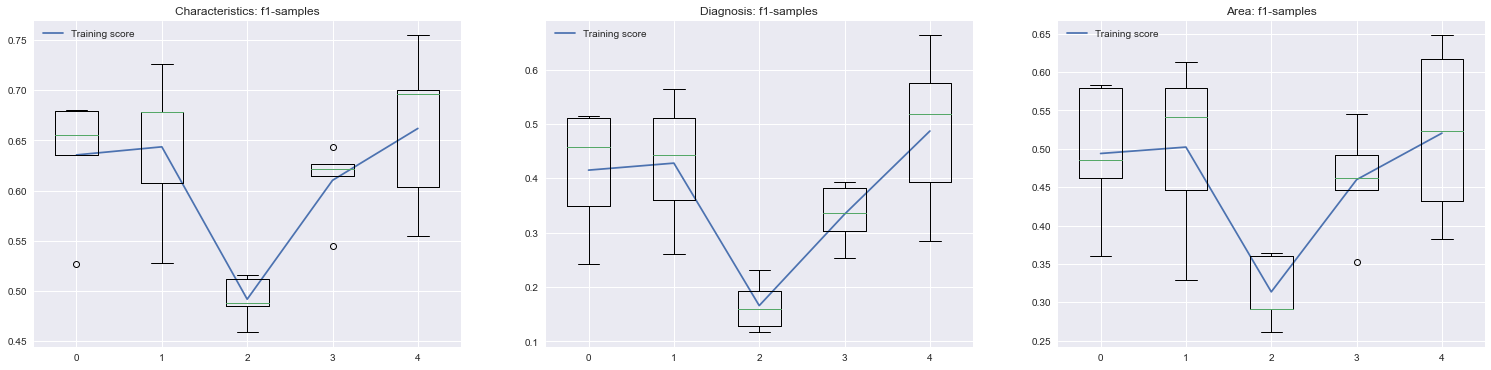

In [39]:
titles = ['Characteristics: f1-samples', 'Diagnosis: f1-samples', 'Area: f1-samples']
scores = [f1_characteristics, f1_diagnosis, f1_area]

figWidth = 26
figHeight = 6
nRow = 1
nCol = len(titles)
epochs = np.arange(0, num_epochs)

fig, axes = plt.subplots(nRow, nCol, figsize = (figWidth, figHeight))
for i in range(0,nRow*nCol):

    r = i//nCol
    c = i%nCol

    # Plot mean training and validation score distributions
    axes[c].plot(epochs, [mean(scores[r+c]['train'][i]) for i in epochs], label='Training score')
    # axes[c].plot(epochs, [mean(scores[r+c]['val'][i]) for i in epochs], label='Validation score')

    # Plot k-fold distribution
    axes[c].boxplot(scores[r+c]['train'], positions=epochs)
    
    axes[c].set_title(titles[i])
    axes[c].legend()
plt.show()